In [1]:
#%pip install matplotlib
#%pip install imageio

In [2]:
import IPython
import os
import json

import torch

from core.schemas import Config

from scripts.generate import *

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio

from tqdm.notebook import tqdm

%matplotlib notebook
reload_model = True

In [3]:
MYPATH = './samples/freddieart/'
CONFIG_FILE = './configs/local.json'
DEVICE = torch.device(os.environ.get("DEVICE", 'cuda' if torch.cuda.is_available() else 'cpu')) #'cpu'
def cap_space(text):
    new_text = ''
    for i, letter in enumerate(text):
        if i and letter.isupper():
            new_text += ' '
        new_text += letter
    return new_text

In [4]:
# clean text file names
image_files = [f for f in os.listdir(MYPATH) if os.path.isfile(os.path.join(MYPATH, f))]

In [5]:
cleaned_file_names = []
for file_name in image_files:
    #remove parens
    file_name = file_name.replace('(', ' ')
    file_name = file_name.replace(')', ' ')
    
    if '+' in file_name:
        #replace + with space
        file_name = file_name.replace('+', ' ')
    elif '_' in file_name:
        file_name = file_name.replace('_', ' ')
    elif ' ' in file_name:
        pass
    else:
        #in files without white space, add space in front of capital letters
        file_name = cap_space(file_name)
    file_name = file_name.replace('  ', ' ')
    file_name = file_name.replace('.jpg', '')
    file_name = file_name.rstrip().lstrip()
    cleaned_file_names.append(file_name)
    

In [6]:
with open(CONFIG_FILE, 'r') as f:
    PARAMS = Config(**json.load(f))
model = load_vqgan_model(PARAMS.vqgan_config, PARAMS.vqgan_checkpoint, PARAMS.models_dir).to(DEVICE)
perceptor = clip.load(PARAMS.clip_model, device=DEVICE, root=PARAMS.models_dir)[0].eval().requires_grad_(False).to(DEVICE)
cut_size = perceptor.visual.input_resolution
make_cutouts = MakeCutouts(PARAMS.augments, cut_size, PARAMS.cutn, cut_pow=PARAMS.cut_pow)

z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

Saving outputs in './outputs'
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Loaded pretrained VGG16 model from './models/vgg16-397923af.pth'
Loaded pretrained LPIPS loss from './models/vgg.pth'
VQLPIPSWithDiscriminator running with hinge loss.
Restored from ./models/vqgan_imagenet_f16_16384.ckpt
Augmentations: [RandomAffine(degrees=15, translate=0.1, scale=None, shear=15, resample=BILINEAR, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), RandomPerspective(distortion_scale=0.5, interpolation=BILINEAR, align_corners=False, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0.0, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False)]


In [7]:
def initialize_params(prompt='a painting'):
    #print(f"Loading default configuration from '{CONFIG_FILE}'")
    with open(CONFIG_FILE, 'r') as f:
        PARAMS = Config(**json.load(f))
    PARAMS.prompts = [prompt]
    PARAMS.init_noise = 'fractal'
    #PARAMS.init_image = './samples/VanGogh.jpg'
    #print(f"Running on {DEVICE}.")
    #print(PARAMS)

    global_seed(PARAMS.seed)

    z = initialize_image(model, PARAMS)
    z_orig = torch.zeros_like(z)
    z.requires_grad_(True)

    prompts = tokenize(model, perceptor, make_cutouts, PARAMS)
    optimizer = get_optimizer(z, PARAMS.optimizer, PARAMS.step_size)
    scheduler = get_scheduler(optimizer, PARAMS.max_iterations, PARAMS.nwarm_restarts)

    kwargs = {
        'model': model,
        'perceptor': perceptor,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'prompts': prompts,
        'make_cutouts': make_cutouts,
        'z_orig': z_orig,
        'z_min': z_min,
        'z_max': z_max,
        'mse_weight': PARAMS.init_weight,
    }
    return PARAMS, kwargs, z

<IPython.core.display.Javascript object>


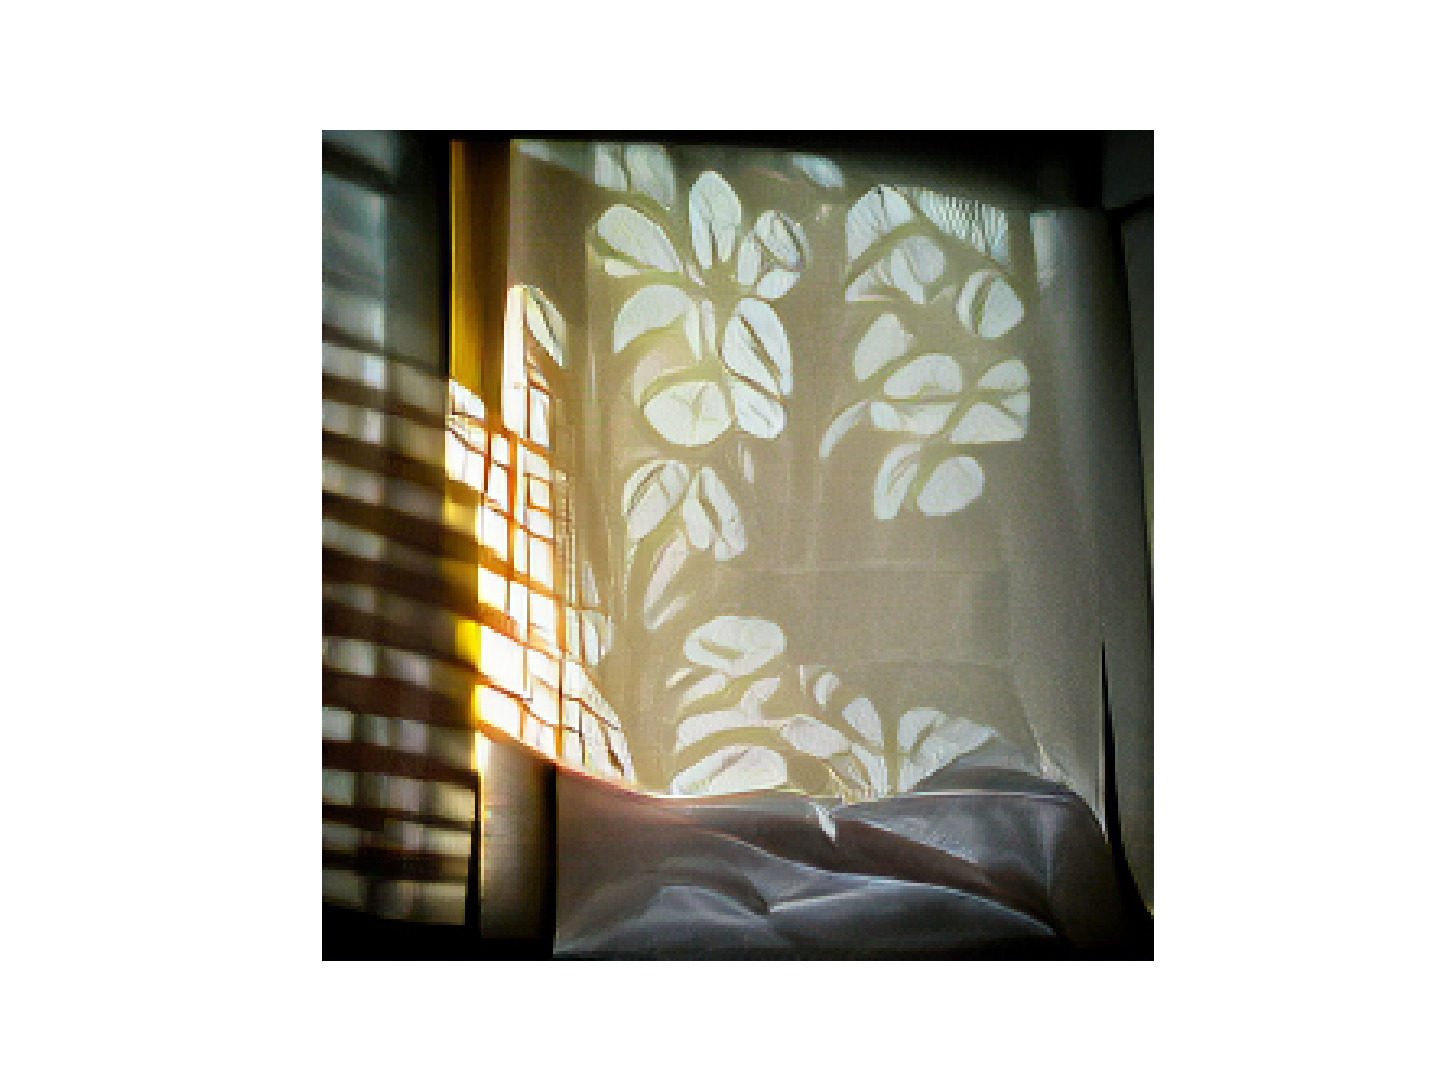

Saving outputs in './outputs'
Global seed set to 2724819371.
Saving outputs in './outputs'
Global seed set to 4137144889.
Saving outputs in './outputs'
Global seed set to 549241796.
Saving outputs in './outputs'
Global seed set to 121675433.
Saving outputs in './outputs'
Global seed set to 349086795.
Saving outputs in './outputs'
Global seed set to 369793083.
Saving outputs in './outputs'
Global seed set to 963329978.
Saving outputs in './outputs'
Global seed set to 3710339645.
Saving outputs in './outputs'
Global seed set to 2009600497.
Saving outputs in './outputs'
Global seed set to 1174953951.
Saving outputs in './outputs'
Global seed set to 700553833.
Saving outputs in './outputs'
Global seed set to 4242465151.
Saving outputs in './outputs'
Global seed set to 3307451031.
Saving outputs in './outputs'
Global seed set to 2039932523.
Saving outputs in './outputs'
Global seed set to 1475639522.
Saving outputs in './outputs'
Global seed set to 1032029404.
Saving outputs in './outputs'


/opt/conda/lib/python3.7/site-packages/kornia/utils/helpers.py:96: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  out1, out2 = torch.solve(input.to(dtype), A.to(dtype))


step: 50, loss: 0.804696, losses: 0.804696
step: 100, loss: 0.780881, losses: 0.780881



KeyboardInterrupt: 

In [8]:
fig,ax = plt.subplots(1,1)

for file_index in tqdm(range(len(cleaned_file_names))):    
    PARAMS, kwargs, z = initialize_params(prompt=cleaned_file_names[file_index])
    output_filename = '_'.join(PARAMS.prompts).replace(' ', '_')
    if os.path.exists(f"{PARAMS.output_dir}/{output_filename}.gif"):
        continue

    tqdm.write(f"prompt: {PARAMS.prompts}")
    for step in range(PARAMS.max_iterations):
        kwargs['step'] = step + 1
        pil_image = train(z, PARAMS, **kwargs)
        if step % 15 == 0:
            ax.imshow(np.asarray(pil_image))
            plt.axis('off')
            fig.canvas.draw()
    
    if len(PARAMS.prompts):
        output_dir = f"{PARAMS.output_dir}/steps/"
        output_image_files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
        output_image_files = sorted(output_image_files)
        images = []
        for filename in output_image_files:
            images.append(imageio.imread(output_dir+filename)) 
        images.append(pil_image)
        imageio.mimsave(f"{PARAMS.output_dir}/{output_filename}.gif", images, duration=1)

In [ ]:
#shutdown kernel
IPython.Application.instance().kernel.do_shutdown(False) 

In [ ]:
output_dir = f"{PARAMS.output_dir}/steps/"
output_image_files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
images = []
for filename in output_image_files:
    images.append(imageio.imread(output_dir+filename))                
output_filename = '_'.join(PARAMS.prompts).replace(' ', '_')
imageio.mimsave(f"{PARAMS.output_dir}/{output_filename}.gif", images, duration=1)